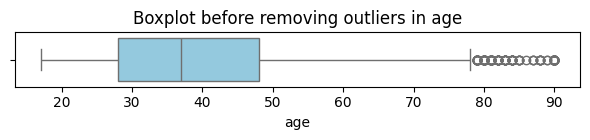

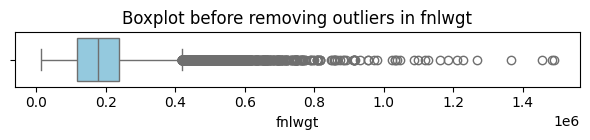

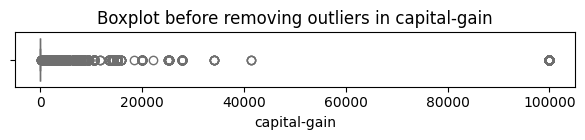

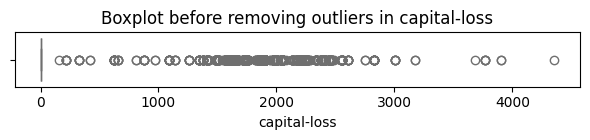

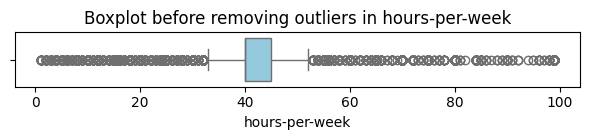

C:\Users\senth\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression Accuracy: 0.8051
RandomForest Accuracy: 0.8230
KNN Accuracy: 0.7584
SVM Accuracy: 0.7861
GradientBoosting Accuracy: 0.8444


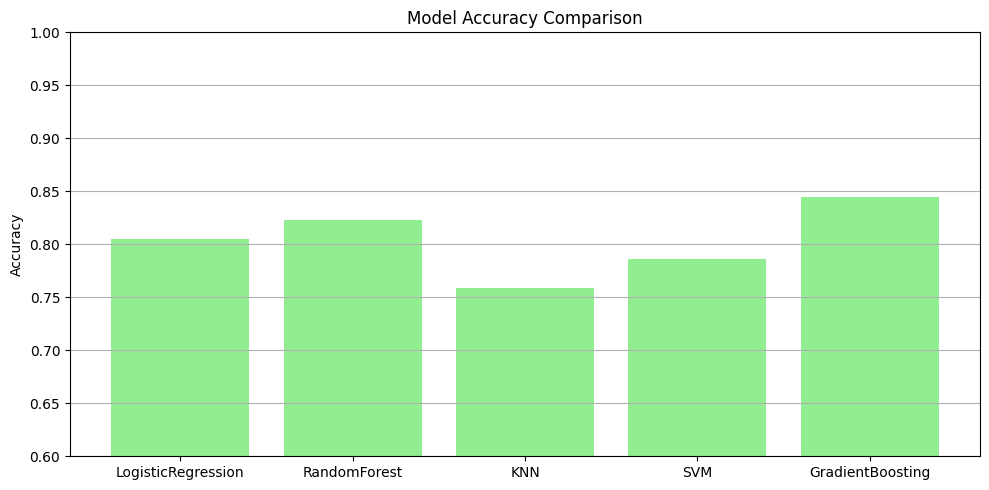


✅ Best model: GradientBoosting with accuracy 0.8444


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load dataset
df = pd.read_csv(r"C:\Users\senth\Downloads\adult 3.csv")

# Replace '?' with 'others'
df.replace("?", "others", inplace=True)

# Drop missing values
df.dropna(inplace=True)

# Outlier Detection & Removal 
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]

numeric_cols = ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']

# Plot and remove outliers
for col in numeric_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(data=df, x=col, color="skyblue")
    plt.title(f'Boxplot before removing outliers in {col}')
    plt.tight_layout()
    plt.show()

    df = remove_outliers_iqr(df, col)

# Encoding Categorical Columns
categorical_cols = [
    "workclass", "education", "marital-status", "occupation",
    "relationship", "race", "gender", "native-country"
]

encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le
    joblib.dump(le, f"{col}_encoder.pkl")  # Save encoder

# Encode target
target_encoder = LabelEncoder()
df["income"] = target_encoder.fit_transform(df["income"])
joblib.dump(target_encoder, "target_encoder.pkl")

# Model Training 
X = df.drop("income", axis=1)
y = df["income"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "GradientBoosting": GradientBoostingClassifier()
}

accuracies = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    print(f"{name} Accuracy: {acc:.4f}")

# Plot Accuracy Comparison 
plt.figure(figsize=(10, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='lightgreen')
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0.6, 1.0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Save Best Model 
best_model_name = max(accuracies, key=accuracies.get)
best_model = models[best_model_name]
joblib.dump(best_model, "best_model.pkl")
print(f"\n✅ Best model: {best_model_name} with accuracy {accuracies[best_model_name]:.4f}")


In [2]:
# app.py

import streamlit as st
import pandas as pd
import joblib

# Load model and encoders
model = joblib.load("best_model.pkl")
encoders = {
    "workclass": joblib.load("workclass_encoder.pkl"),
    "education": joblib.load("education_encoder.pkl"),
    "marital-status": joblib.load("marital-status_encoder.pkl"),
    "occupation": joblib.load("occupation_encoder.pkl"),
    "relationship": joblib.load("relationship_encoder.pkl"),
    "race": joblib.load("race_encoder.pkl"),
    "gender": joblib.load("gender_encoder.pkl"),
    "native-country": joblib.load("native-country_encoder.pkl"),
}
target_encoder = joblib.load("target_encoder.pkl")

st.set_page_config(page_title="Income Prediction", page_icon="💼")
st.title("💼 Predict Income (>50K or <=50K)")

# Sidebar inputs
age = st.sidebar.slider("Age", 18, 90, 30)
workclass = st.sidebar.selectbox("Workclass", encoders["workclass"].classes_)
fnlwgt = st.sidebar.number_input("FNLWGT", 10000, 1000000, 100000)
education = st.sidebar.selectbox("Education", encoders["education"].classes_)
educational_num = st.sidebar.slider("Education Num", 1, 16, 9)
marital_status = st.sidebar.selectbox("Marital Status", encoders["marital-status"].classes_)
occupation = st.sidebar.selectbox("Occupation", encoders["occupation"].classes_)
relationship = st.sidebar.selectbox("Relationship", encoders["relationship"].classes_)
race = st.sidebar.selectbox("Race", encoders["race"].classes_)
gender = st.sidebar.selectbox("Gender", encoders["gender"].classes_)
capital_gain = st.sidebar.number_input("Capital Gain", 0, 100000, 0)
capital_loss = st.sidebar.number_input("Capital Loss", 0, 100000, 0)
hours_per_week = st.sidebar.slider("Hours per Week", 1, 100, 40)
native_country = st.sidebar.selectbox("Native Country", encoders["native-country"].classes_)

# Encode inputs
input_data = pd.DataFrame({
    'age': [age],
    'workclass': [encoders['workclass'].transform([workclass])[0]],
    'fnlwgt': [fnlwgt],
    'education': [encoders['education'].transform([education])[0]],
    'educational-num': [educational_num],
    'marital-status': [encoders['marital-status'].transform([marital_status])[0]],
    'occupation': [encoders['occupation'].transform([occupation])[0]],
    'relationship': [encoders['relationship'].transform([relationship])[0]],
    'race': [encoders['race'].transform([race])[0]],
    'gender': [encoders['gender'].transform([gender])[0]],
    'capital-gain': [capital_gain],
    'capital-loss': [capital_loss],
    'hours-per-week': [hours_per_week],
    'native-country': [encoders['native-country'].transform([native_country])[0]]
})

st.subheader("Input Preview")
st.dataframe(input_data)

if st.button("Predict"):
    pred = model.predict(input_data)
    pred_label = target_encoder.inverse_transform(pred)[0]
    st.success(f"Predicted Income: {pred_label}")


2025-07-21 23:16:56.152 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 23:16:56.160 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 23:16:57.615 
  command:

    streamlit run C:\Users\senth\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-07-21 23:16:57.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 23:16:57.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 23:16:57.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-21 23:16:57.615 Thread 'MainThread': missing ScriptRunContext! This warning can b